In [1]:
# visualize optimization process

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# def seed_all(n=1337):
#   np.random.seed(n)
#   torch.manual_seed(n)
#   random.seed(n)

# seed_all(1288)

In [4]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50,
                 collect_weights = False
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        #             if self.notebook:
        #                 print('Notebook')
        #                 from tqdm.notebook import tqdm, trange
        #             else:
        #                 from tqdm import tqdm, trange
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []
        self.weight_layer_all_epoch = []
        self.weight_all_all_epoch = []
        self.weight_collection_accuracy = []
        self.collect_weights = collect_weights

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))

            # weights collections
            
            if self.collect_weights:
              if epoch%3 == 0:
                weights_layer_epoch = np.zeros(0)
                weights_all_epoch = np.zeros(0)
                for name, parameters in model.named_parameters():
                  if name == 'Dense1.weight':
                    weights_layer_epoch = np.concatenate((weights_layer_epoch, parameters.detach().cpu().numpy().reshape(-1)))
                  
                  if 'weight' in name:
                    weights_all_epoch = np.concatenate((weights_all_epoch, parameters.detach().cpu().numpy().reshape(-1)))

                self.weight_layer_all_epoch.append(weights_layer_epoch)
                self.weight_all_all_epoch.append(weights_all_epoch)
                self.weight_collection_accuracy.append(train_accuracy)
            
            loss_max = val_loss

        if self.collect_weights:
          return self.weight_layer_all_epoch, self.weight_all_all_epoch, self.weight_collection_accuracy, self.training_loss, self.validation_loss

        return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            # target = target.unsqueeze(-1)
            # print('Target Shape - ', target.shape)
            # print('Output Shape - ', output.shape)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            # correct += pred.eq(target.view_as(pred)).sum().item() 
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()
            # batch_acc += (sum(pred.eq(target.view_as(pred)).type(torch.FloatTensor))/len(pred.eq(target.view_as(pred)).type(torch.FloatTensor)))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                # target = target.unsqueeze(-1)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [5]:
class DNN0(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.Dense1 = nn.Linear(28*28, 64)
    self.Dense2 = nn.Linear(64, 32)
    self.Dense3 = nn.Linear(32, 16)
    self.Dense4 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    out = F.log_softmax(x)

    return out


In [6]:
#dataset prepration
bath_size = 128

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs =  16
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/"

In [8]:
def Weights_PCA(Weights):
  Weights = np.array(Weights)
  pca = PCA(n_components=2)
  pca.fit(Weights)
  princ_comps = pca.transform(Weights)
  return princ_comps

In [9]:
#collect weights at Dense1 (64), and weights of whole model
pca_layer = []
pca_all_layers = []
accuracies = []
for i in range(8):
  model = DNN0()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch,
                        collect_weights=True)

  weight_layer_all_epoch, weight_all_all_epoch, weight_collection_accuracy, training_loss, validation_loss = trainer.run_trainer()
  princ_comps_layer =  Weights_PCA(weight_layer_all_epoch)
  princ_all_layers = Weights_PCA(weight_all_all_epoch) 
  pca_layer.append(princ_comps_layer)
  pca_all_layers.append(princ_all_layers)
  accuracies.append(weight_collection_accuracy)



Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 50.97it/s]


Epoch - 0 Train Loss - 1.505584 Val Loss - 0.773388 Train Accuracy - 0.564988 Val Accuracy - 0.800138
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 78.95it/s]


Epoch - 1 Train Loss - 0.599826 Val Loss - 0.465013 Train Accuracy - 0.837198 Val Accuracy - 0.874209
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 82.14it/s]


Epoch - 2 Train Loss - 0.431926 Val Loss - 0.373460 Train Accuracy - 0.881136 Val Accuracy - 0.897053
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 52.30it/s]


Epoch - 3 Train Loss - 0.370550 Val Loss - 0.332721 Train Accuracy - 0.896666 Val Accuracy - 0.904866
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 80.79it/s]


Epoch - 4 Train Loss - 0.339645 Val Loss - 0.315570 Train Accuracy - 0.904723 Val Accuracy - 0.912381
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 80.75it/s]


Epoch - 5 Train Loss - 0.321496 Val Loss - 0.302152 Train Accuracy - 0.909609 Val Accuracy - 0.915546
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 75.21it/s]


Epoch - 6 Train Loss - 0.309262 Val Loss - 0.294044 Train Accuracy - 0.913479 Val Accuracy - 0.917326
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 76.53it/s]


Epoch - 7 Train Loss - 0.300250 Val Loss - 0.287091 Train Accuracy - 0.915301 Val Accuracy - 0.919304
Epoch - 8


validation: 100%|██████████| 79/79 [00:01<00:00, 75.96it/s]


Epoch - 8 Train Loss - 0.293486 Val Loss - 0.284639 Train Accuracy - 0.917805 Val Accuracy - 0.921084
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 78.25it/s]


Epoch - 9 Train Loss - 0.287963 Val Loss - 0.281754 Train Accuracy - 0.918671 Val Accuracy - 0.920985
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 76.38it/s]


Epoch - 10 Train Loss - 0.282880 Val Loss - 0.275351 Train Accuracy - 0.919976 Val Accuracy - 0.922567
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 50.17it/s]


Epoch - 11 Train Loss - 0.278911 Val Loss - 0.274886 Train Accuracy - 0.921336 Val Accuracy - 0.922963
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 79.02it/s]


Epoch - 12 Train Loss - 0.275483 Val Loss - 0.272401 Train Accuracy - 0.922258 Val Accuracy - 0.923161
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 78.44it/s]


Epoch - 13 Train Loss - 0.272626 Val Loss - 0.269687 Train Accuracy - 0.923285 Val Accuracy - 0.925237
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 57.28it/s]


Epoch - 14 Train Loss - 0.269922 Val Loss - 0.268470 Train Accuracy - 0.924363 Val Accuracy - 0.924545
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 78.82it/s]


Epoch - 15 Train Loss - 0.267572 Val Loss - 0.264918 Train Accuracy - 0.925062 Val Accuracy - 0.925633
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 78.57it/s]


Epoch - 0 Train Loss - 1.492352 Val Loss - 0.749704 Train Accuracy - 0.576048 Val Accuracy - 0.805479
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch - 1 Train Loss - 0.585142 Val Loss - 0.464295 Train Accuracy - 0.841923 Val Accuracy - 0.871242
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 79.57it/s]


Epoch - 2 Train Loss - 0.440923 Val Loss - 0.388597 Train Accuracy - 0.876910 Val Accuracy - 0.892306
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 78.82it/s]


Epoch - 3 Train Loss - 0.388787 Val Loss - 0.358841 Train Accuracy - 0.891169 Val Accuracy - 0.900811
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch - 4 Train Loss - 0.358762 Val Loss - 0.333894 Train Accuracy - 0.898804 Val Accuracy - 0.905657
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 77.26it/s]


Epoch - 5 Train Loss - 0.338786 Val Loss - 0.317517 Train Accuracy - 0.904890 Val Accuracy - 0.909810
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 60.28it/s]


Epoch - 6 Train Loss - 0.324583 Val Loss - 0.307370 Train Accuracy - 0.908393 Val Accuracy - 0.911195
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 76.94it/s]


Epoch - 7 Train Loss - 0.313241 Val Loss - 0.302096 Train Accuracy - 0.911642 Val Accuracy - 0.912975
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 80.47it/s]


Epoch - 8 Train Loss - 0.304609 Val Loss - 0.291765 Train Accuracy - 0.914695 Val Accuracy - 0.916040
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 53.84it/s]


Epoch - 9 Train Loss - 0.297250 Val Loss - 0.289596 Train Accuracy - 0.916617 Val Accuracy - 0.918809
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 77.52it/s]


Epoch - 10 Train Loss - 0.291442 Val Loss - 0.281679 Train Accuracy - 0.918288 Val Accuracy - 0.919798
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 78.25it/s]


Epoch - 11 Train Loss - 0.286256 Val Loss - 0.285703 Train Accuracy - 0.919887 Val Accuracy - 0.919897
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 56.64it/s]


Epoch - 12 Train Loss - 0.282171 Val Loss - 0.276468 Train Accuracy - 0.921164 Val Accuracy - 0.921479
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 77.48it/s]


Epoch - 13 Train Loss - 0.278464 Val Loss - 0.282519 Train Accuracy - 0.921592 Val Accuracy - 0.922369
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


Epoch - 14 Train Loss - 0.275301 Val Loss - 0.269642 Train Accuracy - 0.923352 Val Accuracy - 0.924347
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 78.00it/s]


Epoch - 15 Train Loss - 0.272292 Val Loss - 0.269448 Train Accuracy - 0.923285 Val Accuracy - 0.924051
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 77.88it/s]


Epoch - 0 Train Loss - 1.482671 Val Loss - 0.818033 Train Accuracy - 0.575521 Val Accuracy - 0.782338
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 80.24it/s]


Epoch - 1 Train Loss - 0.609353 Val Loss - 0.474989 Train Accuracy - 0.831079 Val Accuracy - 0.870352
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 79.29it/s]


Epoch - 2 Train Loss - 0.440470 Val Loss - 0.394799 Train Accuracy - 0.875483 Val Accuracy - 0.889142
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 76.54it/s]


Epoch - 3 Train Loss - 0.386817 Val Loss - 0.360105 Train Accuracy - 0.890009 Val Accuracy - 0.897943
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 52.47it/s]


Epoch - 4 Train Loss - 0.357441 Val Loss - 0.337051 Train Accuracy - 0.898338 Val Accuracy - 0.903085
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 76.69it/s]


Epoch - 5 Train Loss - 0.338305 Val Loss - 0.323376 Train Accuracy - 0.903018 Val Accuracy - 0.907733
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 79.69it/s]


Epoch - 6 Train Loss - 0.323475 Val Loss - 0.312552 Train Accuracy - 0.908271 Val Accuracy - 0.910502
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 53.97it/s]


Epoch - 7 Train Loss - 0.312232 Val Loss - 0.304725 Train Accuracy - 0.911197 Val Accuracy - 0.914656
Epoch - 8


validation: 100%|██████████| 79/79 [00:01<00:00, 78.22it/s]


Epoch - 8 Train Loss - 0.303210 Val Loss - 0.297442 Train Accuracy - 0.914229 Val Accuracy - 0.915249
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 81.03it/s]


Epoch - 9 Train Loss - 0.295781 Val Loss - 0.289186 Train Accuracy - 0.915678 Val Accuracy - 0.916634
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 66.60it/s]


Epoch - 10 Train Loss - 0.289742 Val Loss - 0.285313 Train Accuracy - 0.917755 Val Accuracy - 0.919007
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 79.92it/s]


Epoch - 11 Train Loss - 0.284692 Val Loss - 0.284202 Train Accuracy - 0.919982 Val Accuracy - 0.918710
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


Epoch - 12 Train Loss - 0.280498 Val Loss - 0.288768 Train Accuracy - 0.920098 Val Accuracy - 0.919403
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 77.82it/s]


Epoch - 13 Train Loss - 0.276961 Val Loss - 0.274224 Train Accuracy - 0.921597 Val Accuracy - 0.921578
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 78.41it/s]


Epoch - 14 Train Loss - 0.273771 Val Loss - 0.279838 Train Accuracy - 0.922613 Val Accuracy - 0.921974
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 58.11it/s]


Epoch - 15 Train Loss - 0.271189 Val Loss - 0.274391 Train Accuracy - 0.923807 Val Accuracy - 0.923062
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 80.29it/s]


Epoch - 0 Train Loss - 1.442061 Val Loss - 0.697989 Train Accuracy - 0.599963 Val Accuracy - 0.815665
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 79.53it/s]


Epoch - 1 Train Loss - 0.553223 Val Loss - 0.446139 Train Accuracy - 0.850080 Val Accuracy - 0.875890
Epoch - 2


validation: 100%|██████████| 79/79 [00:01<00:00, 53.95it/s]


Epoch - 2 Train Loss - 0.417119 Val Loss - 0.375250 Train Accuracy - 0.884240 Val Accuracy - 0.895273
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 77.88it/s]


Epoch - 3 Train Loss - 0.369561 Val Loss - 0.344399 Train Accuracy - 0.896666 Val Accuracy - 0.902097
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 81.09it/s]


Epoch - 4 Train Loss - 0.344627 Val Loss - 0.326741 Train Accuracy - 0.903835 Val Accuracy - 0.907140
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 67.35it/s]


Epoch - 5 Train Loss - 0.328327 Val Loss - 0.319972 Train Accuracy - 0.907783 Val Accuracy - 0.909711
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 77.24it/s]


Epoch - 6 Train Loss - 0.317351 Val Loss - 0.310409 Train Accuracy - 0.910920 Val Accuracy - 0.912184
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 78.95it/s]


Epoch - 7 Train Loss - 0.308758 Val Loss - 0.301941 Train Accuracy - 0.912702 Val Accuracy - 0.915249
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 80.41it/s]


Epoch - 8 Train Loss - 0.302469 Val Loss - 0.299948 Train Accuracy - 0.915251 Val Accuracy - 0.913568
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 79.24it/s]


Epoch - 9 Train Loss - 0.297319 Val Loss - 0.294953 Train Accuracy - 0.916717 Val Accuracy - 0.916535
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


Epoch - 10 Train Loss - 0.292769 Val Loss - 0.295338 Train Accuracy - 0.917355 Val Accuracy - 0.918315
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 78.16it/s]


Epoch - 11 Train Loss - 0.289028 Val Loss - 0.289972 Train Accuracy - 0.918727 Val Accuracy - 0.919205
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 75.84it/s]


Epoch - 12 Train Loss - 0.285513 Val Loss - 0.293881 Train Accuracy - 0.920131 Val Accuracy - 0.918513
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 51.33it/s]


Epoch - 13 Train Loss - 0.282495 Val Loss - 0.283270 Train Accuracy - 0.920981 Val Accuracy - 0.921381
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 77.77it/s]


Epoch - 14 Train Loss - 0.279957 Val Loss - 0.281479 Train Accuracy - 0.921720 Val Accuracy - 0.921381
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 76.63it/s]


Epoch - 15 Train Loss - 0.277391 Val Loss - 0.282833 Train Accuracy - 0.922675 Val Accuracy - 0.921381
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 52.02it/s]


Epoch - 0 Train Loss - 1.464403 Val Loss - 0.724043 Train Accuracy - 0.601235 Val Accuracy - 0.813983
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 70.17it/s]


Epoch - 1 Train Loss - 0.557923 Val Loss - 0.439916 Train Accuracy - 0.846871 Val Accuracy - 0.877077
Epoch - 2


validation: 100%|██████████| 79/79 [00:01<00:00, 75.69it/s]


Epoch - 2 Train Loss - 0.419632 Val Loss - 0.379454 Train Accuracy - 0.881830 Val Accuracy - 0.894383
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 53.84it/s]


Epoch - 3 Train Loss - 0.374433 Val Loss - 0.349626 Train Accuracy - 0.894206 Val Accuracy - 0.901404
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 71.93it/s]


Epoch - 4 Train Loss - 0.351605 Val Loss - 0.333665 Train Accuracy - 0.900553 Val Accuracy - 0.904173
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 77.39it/s]


Epoch - 5 Train Loss - 0.336825 Val Loss - 0.323770 Train Accuracy - 0.904462 Val Accuracy - 0.904569
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 71.51it/s]


Epoch - 6 Train Loss - 0.326488 Val Loss - 0.315982 Train Accuracy - 0.907871 Val Accuracy - 0.908623
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 76.70it/s]


Epoch - 7 Train Loss - 0.318832 Val Loss - 0.310291 Train Accuracy - 0.909870 Val Accuracy - 0.908623
Epoch - 8


validation: 100%|██████████| 79/79 [00:01<00:00, 77.68it/s]


Epoch - 8 Train Loss - 0.312466 Val Loss - 0.305986 Train Accuracy - 0.912064 Val Accuracy - 0.912678
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 77.57it/s]


Epoch - 9 Train Loss - 0.306405 Val Loss - 0.301185 Train Accuracy - 0.913629 Val Accuracy - 0.911689
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 76.59it/s]


Epoch - 10 Train Loss - 0.301349 Val Loss - 0.302264 Train Accuracy - 0.915873 Val Accuracy - 0.913568
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 61.93it/s]


Epoch - 11 Train Loss - 0.296610 Val Loss - 0.296231 Train Accuracy - 0.916911 Val Accuracy - 0.914656
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 78.27it/s]


Epoch - 12 Train Loss - 0.292050 Val Loss - 0.287825 Train Accuracy - 0.918632 Val Accuracy - 0.917623
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 78.40it/s]


Epoch - 13 Train Loss - 0.287722 Val Loss - 0.292324 Train Accuracy - 0.919210 Val Accuracy - 0.917919
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 52.56it/s]


Epoch - 14 Train Loss - 0.283730 Val Loss - 0.282811 Train Accuracy - 0.920665 Val Accuracy - 0.921479
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 78.56it/s]


Epoch - 15 Train Loss - 0.279943 Val Loss - 0.281463 Train Accuracy - 0.921486 Val Accuracy - 0.920688
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 77.24it/s]


Epoch - 0 Train Loss - 1.482505 Val Loss - 0.754294 Train Accuracy - 0.572317 Val Accuracy - 0.812302
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 53.77it/s]


Epoch - 1 Train Loss - 0.573066 Val Loss - 0.436833 Train Accuracy - 0.845355 Val Accuracy - 0.879252
Epoch - 2


validation: 100%|██████████| 79/79 [00:01<00:00, 78.65it/s]


Epoch - 2 Train Loss - 0.420507 Val Loss - 0.372888 Train Accuracy - 0.882452 Val Accuracy - 0.894086
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 78.50it/s]


Epoch - 3 Train Loss - 0.374671 Val Loss - 0.348200 Train Accuracy - 0.894773 Val Accuracy - 0.900811
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 66.06it/s]


Epoch - 4 Train Loss - 0.349763 Val Loss - 0.331700 Train Accuracy - 0.900786 Val Accuracy - 0.907140
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 76.54it/s]


Epoch - 5 Train Loss - 0.332237 Val Loss - 0.313177 Train Accuracy - 0.906189 Val Accuracy - 0.910700
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 74.77it/s]


Epoch - 6 Train Loss - 0.319377 Val Loss - 0.302548 Train Accuracy - 0.909404 Val Accuracy - 0.912777
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 77.80it/s]


Epoch - 7 Train Loss - 0.309008 Val Loss - 0.299385 Train Accuracy - 0.912369 Val Accuracy - 0.914656
Epoch - 8


validation: 100%|██████████| 79/79 [00:01<00:00, 77.60it/s]


Epoch - 8 Train Loss - 0.301141 Val Loss - 0.294433 Train Accuracy - 0.914312 Val Accuracy - 0.917227
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 65.26it/s]


Epoch - 9 Train Loss - 0.294085 Val Loss - 0.292186 Train Accuracy - 0.917200 Val Accuracy - 0.917623
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 79.68it/s]


Epoch - 10 Train Loss - 0.288679 Val Loss - 0.284467 Train Accuracy - 0.918227 Val Accuracy - 0.918908
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 78.89it/s]


Epoch - 11 Train Loss - 0.283770 Val Loss - 0.286569 Train Accuracy - 0.919637 Val Accuracy - 0.919699
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 51.63it/s]


Epoch - 12 Train Loss - 0.279434 Val Loss - 0.278210 Train Accuracy - 0.921559 Val Accuracy - 0.922073
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 76.90it/s]


Epoch - 13 Train Loss - 0.276164 Val Loss - 0.278076 Train Accuracy - 0.922519 Val Accuracy - 0.921875
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 78.64it/s]


Epoch - 14 Train Loss - 0.273363 Val Loss - 0.273050 Train Accuracy - 0.923113 Val Accuracy - 0.923457
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 53.69it/s]


Epoch - 15 Train Loss - 0.270675 Val Loss - 0.273866 Train Accuracy - 0.923841 Val Accuracy - 0.924347
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 80.44it/s]


Epoch - 0 Train Loss - 1.454687 Val Loss - 0.752017 Train Accuracy - 0.583206 Val Accuracy - 0.801919
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 78.68it/s]


Epoch - 1 Train Loss - 0.586919 Val Loss - 0.480267 Train Accuracy - 0.837120 Val Accuracy - 0.866199
Epoch - 2


validation: 100%|██████████| 79/79 [00:01<00:00, 71.35it/s]


Epoch - 2 Train Loss - 0.449204 Val Loss - 0.411746 Train Accuracy - 0.872696 Val Accuracy - 0.882417
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 78.28it/s]


Epoch - 3 Train Loss - 0.403447 Val Loss - 0.379054 Train Accuracy - 0.885394 Val Accuracy - 0.890724
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 76.41it/s]


Epoch - 4 Train Loss - 0.378950 Val Loss - 0.363869 Train Accuracy - 0.891636 Val Accuracy - 0.895767
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 77.86it/s]


Epoch - 5 Train Loss - 0.362493 Val Loss - 0.347890 Train Accuracy - 0.897183 Val Accuracy - 0.899921
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 76.68it/s]


Epoch - 6 Train Loss - 0.349521 Val Loss - 0.342206 Train Accuracy - 0.900431 Val Accuracy - 0.901701
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 61.90it/s]


Epoch - 7 Train Loss - 0.338832 Val Loss - 0.330064 Train Accuracy - 0.904046 Val Accuracy - 0.904569
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 80.66it/s]


Epoch - 8 Train Loss - 0.329303 Val Loss - 0.322441 Train Accuracy - 0.907222 Val Accuracy - 0.906646
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 75.47it/s]


Epoch - 9 Train Loss - 0.320367 Val Loss - 0.312779 Train Accuracy - 0.909532 Val Accuracy - 0.911392
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 53.60it/s]


Epoch - 10 Train Loss - 0.311773 Val Loss - 0.304482 Train Accuracy - 0.912252 Val Accuracy - 0.912777
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 78.75it/s]


Epoch - 11 Train Loss - 0.303948 Val Loss - 0.301588 Train Accuracy - 0.914396 Val Accuracy - 0.912678
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 76.74it/s]


Epoch - 12 Train Loss - 0.296547 Val Loss - 0.292904 Train Accuracy - 0.916539 Val Accuracy - 0.916436
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 56.13it/s]


Epoch - 13 Train Loss - 0.290467 Val Loss - 0.287007 Train Accuracy - 0.918216 Val Accuracy - 0.919699
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 78.81it/s]


Epoch - 14 Train Loss - 0.284983 Val Loss - 0.284895 Train Accuracy - 0.919898 Val Accuracy - 0.919304
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 77.50it/s]


Epoch - 15 Train Loss - 0.280514 Val Loss - 0.282151 Train Accuracy - 0.920909 Val Accuracy - 0.917722
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-5-763a3db17a3f>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:01<00:00, 72.26it/s]


Epoch - 0 Train Loss - 1.460417 Val Loss - 0.685455 Train Accuracy - 0.624062 Val Accuracy - 0.826938
Epoch - 1


validation: 100%|██████████| 79/79 [00:01<00:00, 77.97it/s]


Epoch - 1 Train Loss - 0.535884 Val Loss - 0.425583 Train Accuracy - 0.850530 Val Accuracy - 0.880835
Epoch - 2


validation: 100%|██████████| 79/79 [00:01<00:00, 77.97it/s]


Epoch - 2 Train Loss - 0.405029 Val Loss - 0.366971 Train Accuracy - 0.884134 Val Accuracy - 0.894976
Epoch - 3


validation: 100%|██████████| 79/79 [00:01<00:00, 77.09it/s]


Epoch - 3 Train Loss - 0.360975 Val Loss - 0.350775 Train Accuracy - 0.897555 Val Accuracy - 0.900119
Epoch - 4


validation: 100%|██████████| 79/79 [00:01<00:00, 76.70it/s]


Epoch - 4 Train Loss - 0.337611 Val Loss - 0.328309 Train Accuracy - 0.903824 Val Accuracy - 0.905261
Epoch - 5


validation: 100%|██████████| 79/79 [00:01<00:00, 60.33it/s]


Epoch - 5 Train Loss - 0.322535 Val Loss - 0.313239 Train Accuracy - 0.908832 Val Accuracy - 0.909513
Epoch - 6


validation: 100%|██████████| 79/79 [00:01<00:00, 77.86it/s]


Epoch - 6 Train Loss - 0.311367 Val Loss - 0.306821 Train Accuracy - 0.911891 Val Accuracy - 0.912085
Epoch - 7


validation: 100%|██████████| 79/79 [00:01<00:00, 78.29it/s]


Epoch - 7 Train Loss - 0.302580 Val Loss - 0.296204 Train Accuracy - 0.914623 Val Accuracy - 0.915645
Epoch - 8


validation: 100%|██████████| 79/79 [00:01<00:00, 52.42it/s]


Epoch - 8 Train Loss - 0.295775 Val Loss - 0.297456 Train Accuracy - 0.916456 Val Accuracy - 0.916831
Epoch - 9


validation: 100%|██████████| 79/79 [00:01<00:00, 77.12it/s]


Epoch - 9 Train Loss - 0.290174 Val Loss - 0.290548 Train Accuracy - 0.918049 Val Accuracy - 0.919304
Epoch - 10


validation: 100%|██████████| 79/79 [00:01<00:00, 77.70it/s]


Epoch - 10 Train Loss - 0.285343 Val Loss - 0.289882 Train Accuracy - 0.920120 Val Accuracy - 0.919205
Epoch - 11


validation: 100%|██████████| 79/79 [00:01<00:00, 54.53it/s]


Epoch - 11 Train Loss - 0.281144 Val Loss - 0.281181 Train Accuracy - 0.921459 Val Accuracy - 0.920392
Epoch - 12


validation: 100%|██████████| 79/79 [00:01<00:00, 78.50it/s]


Epoch - 12 Train Loss - 0.277743 Val Loss - 0.277806 Train Accuracy - 0.922697 Val Accuracy - 0.921974
Epoch - 13


validation: 100%|██████████| 79/79 [00:01<00:00, 77.66it/s]


Epoch - 13 Train Loss - 0.274508 Val Loss - 0.278570 Train Accuracy - 0.923213 Val Accuracy - 0.921084
Epoch - 14


validation: 100%|██████████| 79/79 [00:01<00:00, 78.24it/s]


Epoch - 14 Train Loss - 0.271834 Val Loss - 0.274406 Train Accuracy - 0.924229 Val Accuracy - 0.923655
Epoch - 15


validation: 100%|██████████| 79/79 [00:01<00:00, 77.21it/s]


Epoch - 15 Train Loss - 0.269390 Val Loss - 0.273678 Train Accuracy - 0.924635 Val Accuracy - 0.923754


In [10]:
def plot_pca(pca_layer, accuracies, plot_name):
  fig = plt.figure(figsize=(15,15))
  plt.xlabel('Weight PC1')
  plt.ylabel('Weight PC2')
  plt.title(plot_name)
  for i in range(8):
    W_i = pca_layer[i]
    plt.scatter(W_i[:,0], W_i[:,1])
    for j in range(len(W_i)):
      plt.annotate(round(accuracies[i][j],1), (W_i[j,0],W_i[j,1]))
  plt.show()
  fig.savefig(os.path.join(path2write, plot_name))

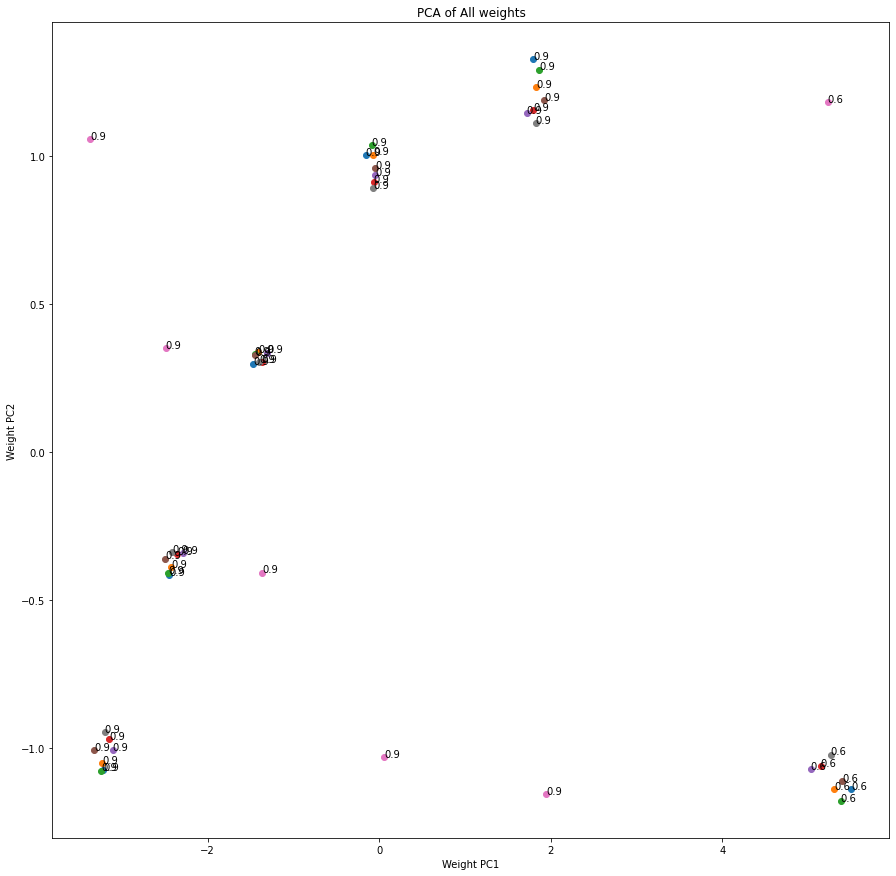

In [11]:
plot_pca(pca_all_layers, accuracies, 'PCA of All weights')

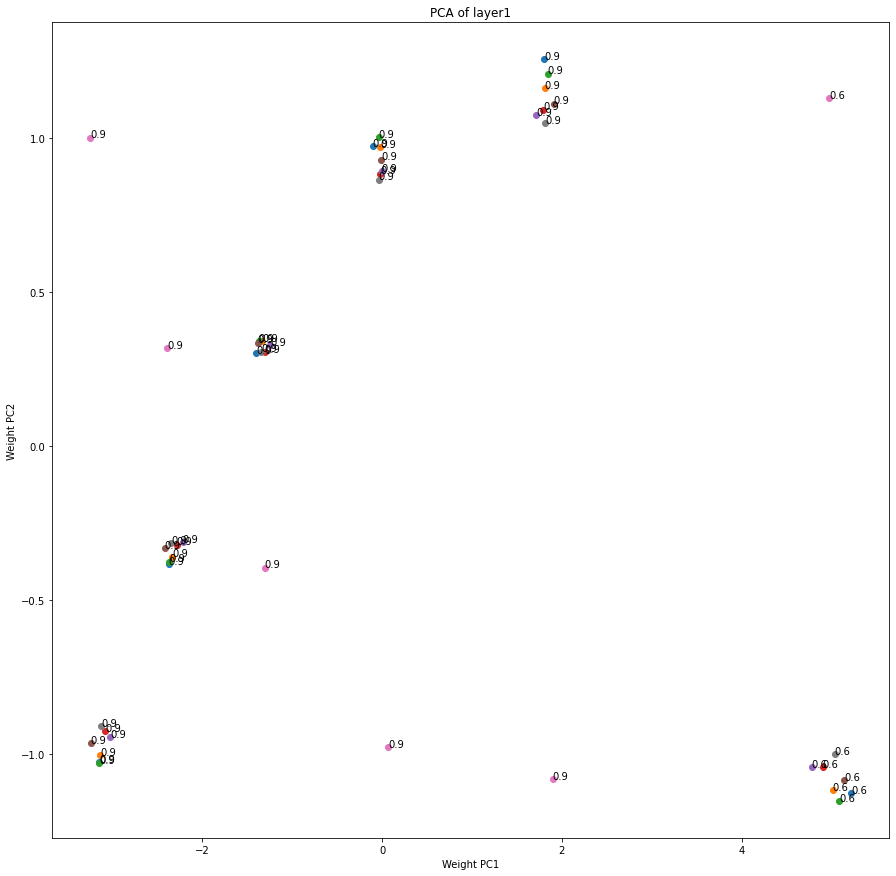

In [13]:
plot_pca(pca_layer, accuracies, 'PCA of layer1')

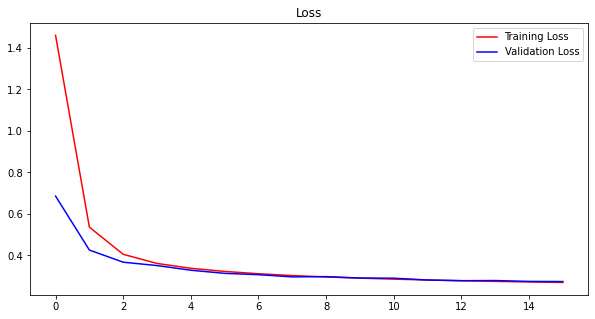

In [15]:
training_loss, validation_loss
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(training_loss, 'r-', label='Training Loss')
ax1.plot(validation_loss, 'b-', label='Validation Loss')
ax1.legend()
ax1.set_title('Loss')
fig.savefig(os.path.join(path2write, 'PCA Training Loss.png'))

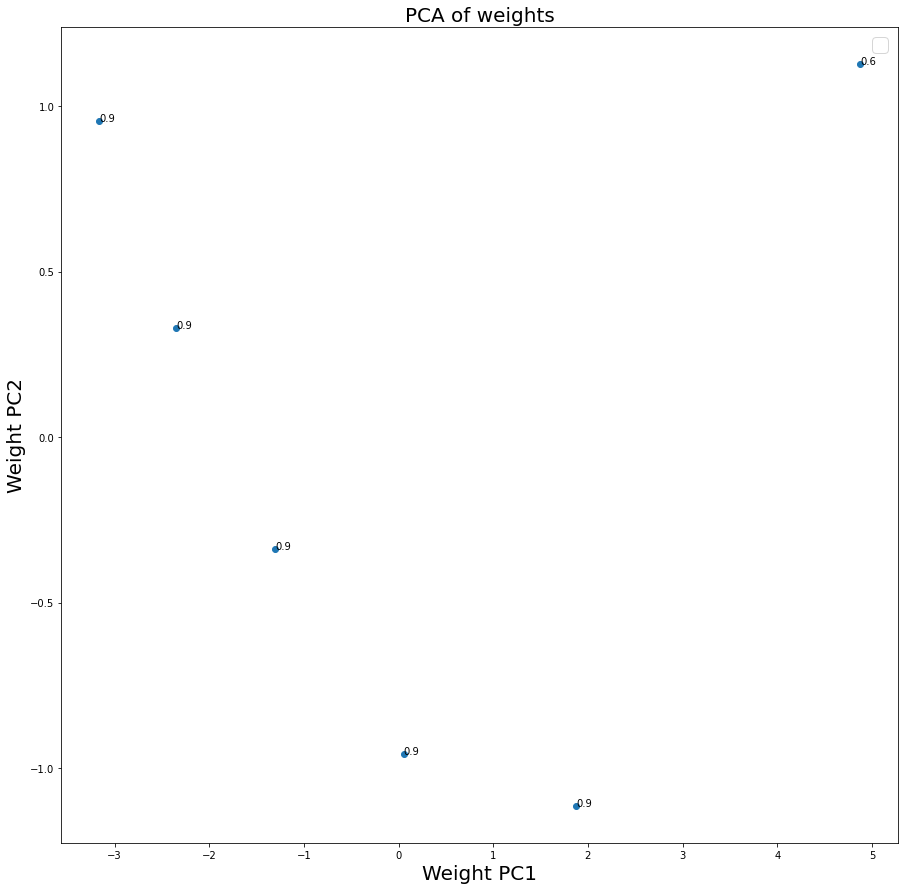

In [ ]:
# plt.figure(figsize=(15,15))
# plt.xlabel('Weight PC1',fontsize=20)
# plt.ylabel('Weight PC2',fontsize=20)
# plt.title('PCA of weights',fontsize=20)
# plt.legend(fontsize=20)
# for i in range(8):
#   W_i = pca_layer[i]
#   plt.scatter(W_i[:,0], W_i[:,1])
#   for j in range(len(W_i)):
#     plt.annotate(round(accuracies[i][j].item(),1), (W_i[j,0],W_i[j,1]))
#   break
# plt.show()

# plt.figure(figsize=(20,10))
# plt.xlabel('Weight1',fontsize=20)
# plt.ylabel('Weight2',fontsize=20)
# plt.title('Weights of our layer',fontsize=20)
# for i in range(events):
# W_i = W2[i]
# plt.scatter(W_i[:,0], W_i[:,1])
# for j in range(len(W_i)):
# plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))
# plt.show()

In [ ]:
weights_all_epoch.shape

(52896,)